# Algoritmos de busca aplicados ao escalonamento de tarefas com 2 processadores

Em primeiro lugar, precisamos elaborar como é definido o problema. Basicamente, temos um grafo direcionado acíclico, onde
os nós representam as tarefas a serem escalonadas e as arestas representam o tempo de comunicação entre as tarefas. A direção das arestas significa que o próximo depende do anterior. Ou seja, se existe uma aresta entre A e B e a seta aponta para B, isso significa que a tarefa B depende da tarefa A.  

O tempo de comunicação é levado em consideração *somente* quando duas tarefas não estão no mesmo processador. Daí, existem um tempo para que se comunique ao processo a informação que ele precisa. Exceto esse caso, ou seja, se as tarefas forem executadas todos no mesmo processador, o tempo de comunicação é desconsiderado. 

Vamos ver um exemplo mais prático disso. Veja essa representação de grafo, usando a notação `.dot`:

```dot
strict digraph "" {
	0	[execution_time=1];
	1	[execution_time=2];
	3	[execution_time=2];
	2	[execution_time=4];
	0 -> 1	[weight=1];
	0 -> 2	[weight=1];
	1 -> 3	[weight=1]
}
```

Esse é exatamente o grafo mais simples presente no material de apoio "Escalonamento de Tarefas
em Multiprocessadores". Usando o `pyplot` podemos confirmar isso visualmente:


/home/bufulin/Desktop/IA-trabalho-1/relatorio/../tests/task_scheduling/simple_example


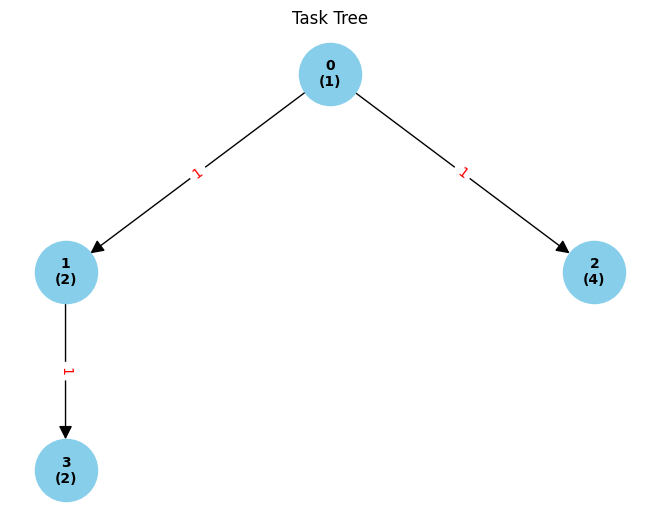

In [1]:
import sys
import os

# === ignore this step, just imports ===
# foi preciso importar de alguma maneira o código do repositório aqui e esse foi
# o jeito mais fácil
sys.path.append(os.path.join(os.getcwd(), '..'))

from task_scheduling import *
from algorithms import *

import os
from IPython.core.getipython import get_ipython
# Get the current notebook's path
notebook_path = get_ipython().getoutput('pwd')[0]
# === 
file_path = os.path.join(notebook_path, "../tests/task_scheduling/simple_example")
print(file_path)

G = read_graph(file_path)
draw(G)

Agora, tendo um grafo que representa um exemplo de espaço de busca do problema, podemos visualizar um exemplo de uma
solução possível por meio de um gráfico de Gantt. Para issofoi criada uma classe para representar o que é um estado para esse problema de escalonamento em `/task_scheduling/system_types.py`, onde essa classe tem uma função útil para visualizar como está a distribuição de tarefas entre os processadores. 

Veja abaixo como se usa a nossa abstração de um estado e ao mesmo tempo como visualizar um estado criado.

In [2]:

tasks_p1 = [
Task(node_id=0, execution_time=1, communication_time=0),
Task(node_id=1, execution_time=2, communication_time=0, dependencies=[0]),
Task(node_id=3, execution_time=2, communication_time=0, dependencies=[1]),
]
tasks_p2 = [
    Task(node_id=2, execution_time=4, communication_time=1, dependencies=[0]),
]


processor_A = ProcessorState(tasks_p1)

task3 = Task(node_id=3, execution_time=3)
processor_B = ProcessorState(tasks_p2)

system = SystemState([processor_A, processor_B])
system.plot_gantt_chart()

No exemplo acima, o gráfico de Gantt que resolve o problema de escalonamento mais simples que foi citado. Também é possível visualizar o acréscimo do tempo de comunicação entre os processadores A e B, dado que a tarefa 2 está no processador B e ela depende da tarefa 0 que terminou no processador A.

Veja abaixo mais um exemplo:

In [3]:

tasks_p1 = [
Task(node_id=0, execution_time=1, communication_time=0),
Task(node_id=1, execution_time=2, communication_time=0, dependencies=[0]),
Task(node_id=2, execution_time=4, communication_time=0, dependencies=[0]),
]
tasks_p2 = [
Task(node_id=3, execution_time=2, communication_time=1, dependencies=[1]),
]

processor1 = ProcessorState(tasks_p1)
processor2 = ProcessorState(tasks_p2)

system = SystemState([processor1, processor2])
system.plot_gantt_chart()

Nesse caso, o tempo de comunicação existe na tarefa 3.

## Funções auxiliares para os algoritmos
Como construímos os algoritmos de busca para serem agnósticos aos dois problemas desse projeto, precisamos implementar algumas funções que são usadas internamente por esses algoritmos. Essas funções fazem a parte de implementar a lógica específica de cada problema.



Vamos começar pela função que cria o primeiro estado do problema, a `initialize_system`:

In [4]:
init_state = initialize_system(G, 2)
print(init_state)


  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 1



Essa função seleciona o nó raiz ,que contém a tarefa inicial, e cria um `SystemState` com 2 processadores (podendo passar arbitrariamente quantos processadores forem necessários) assinalando a tarefa ao primeiro processador. Foi criada uma abstração para escrever o estado de uma maneira legível humanamente como pode ver acima.

Veja agora a função `goal_check` abaixo:

In [5]:
a = goal_check(system,G)
b = goal_check(init_state, G)

print(a,b)

True False


Um sistema é tido como final se todas as tarefas estão alocadas. A função retorna `True` se o estado é final, e `False` caso contrário.

Note que essa função não checa se a ordem das tarefas está correta, ela já assume que o estado é válido. Ordenar adequadamente as tarefas nos processadores de forma que o estado seja válido é uma tarefa que precisa estar feita antes de usar essa função. 

Agora, a função `find_neighbors`:

In [6]:
neighbors = find_neighbors(init_state,G)

for idx, neighbor in enumerate(neighbors):
    print("neighbor ",idx, "\n", neighbor)

neighbor  0 
 
  Processor 0, total time: 3 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 2, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 3

neighbor  1 
 
  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
  Processor 1, total time: 3 (with communication time: 1):
    - Task ID: 1, Execution Time: 2, Communication Time: 1
System end time: 4

neighbor  2 
 
  Processor 0, total time: 5 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 5

neighbor  3 
 
  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Commun

O que essa função faz é encontrar as próximas tarefas que podem ser alocadas e disponibilizar tudo em uma lista de vizinhos. 

Essa função também lida com a inserção correta dos tempos de comunicação quando é necessário. Por exemplo, vamos supor que escolhemos um dos estados anteriores. Se as próximas tarefas alocadas nos processadores, no próximo estado, dependerem de tarefas de processadores diferentes, a função `find_neighbors` levará em consideração o tempo de comunicação e fará sua adição ao tempo de finalização do sistema.

Veja abaixo também a função encontrando a vizinhança de um vizinho anterior escolhido:

In [7]:
node = neighbors[0]
neighbors = find_neighbors(node,G)

In [8]:
for idx, neighbor in enumerate(neighbors):
    print("neighbor ",idx, "\n", neighbor)

neighbor  0 
 
  Processor 0, total time: 5 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 2, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 5

neighbor  1 
 
  Processor 0, total time: 3 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 2, Communication Time: 0
  Processor 1, total time: 3 (with communication time: 1):
    - Task ID: 3, Execution Time: 2, Communication Time: 1
System end time: 4

neighbor  2 
 
  Processor 0, total time: 7 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 2, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 0 (with communication time:

A próxima função importante é a `cost_between`. O trabalho dela é simplesmente retornar a diferença entre os custos de dois estados. 
Essa função é usada nos algoritmos de busca para definir os custos (peso das arestas) entre um nó e seus vizinhos. Veja abaixo:

In [9]:
print(cost_between(node, neighbors[0], G))
print(cost_between(node, neighbors[1], G))


2
1


A última, mas não menos importante, é a função da `heuristic`. A ideia dessa heurística é estimar a média de recursos necessários.
Nessa heurística, é somado o tempo de todas as tarefas ainda não alocadas nos processadores e isso é dividido pela quantidade de processadores. Essa heurística é admissível (nunca superestima, é otimista) porque ela assume paralelização perfeita, o que nunca é pior que o resultado verdadeiro. 

Veja abaixo como isso funciona, vamos reinicializar o primeiro estado para ficar mais evidente:

In [10]:
init_state = initialize_system(G, 2)
print(init_state)
print('heuristic for this state: ', heuristic(init_state, G))


  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 1

heuristic for this state:  4.0


No caso, como apenas a tarefa 0 estava alocada no primeiro processador, existiam as tarefas 1,2 e 3 ainda para serem alocadas. Somando-se o tempo de execução dessas tarefas (desconsiderando o tempo de comunicação) temos que tempo mais otimista para executá-las seria 4.

# Experimentos

Com todas essas funções, podemos aplicar elas nos algoritmos para encontrar as soluções para os problemas de escalonamento. Veja abaixo a aplicação no algoritmo A estrela, busca gulosa e busca em profundidade iterativa.

No material de apoio foram deixados dois grafos que vamos usar nos nossos algoritmos implementados aqui também. Veja os grafos abaixo, criamos eles em arquivos `.dot` também:

/home/bufulin/Desktop/IA-trabalho-1/relatorio/graph1


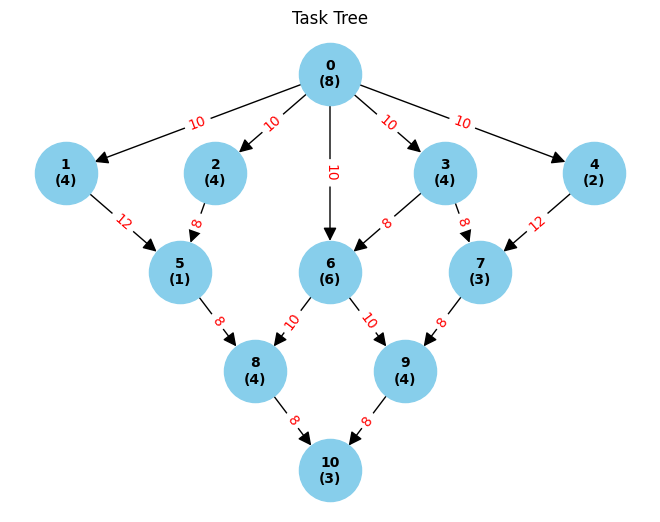

In [11]:
# Now, you can join the notebook path with the relative path to your file
file_path = os.path.join(notebook_path, "graph1")
print(file_path)

Gex_1 = read_graph(file_path)
draw(Gex_1)

/home/bufulin/Desktop/IA-trabalho-1/relatorio/graph2


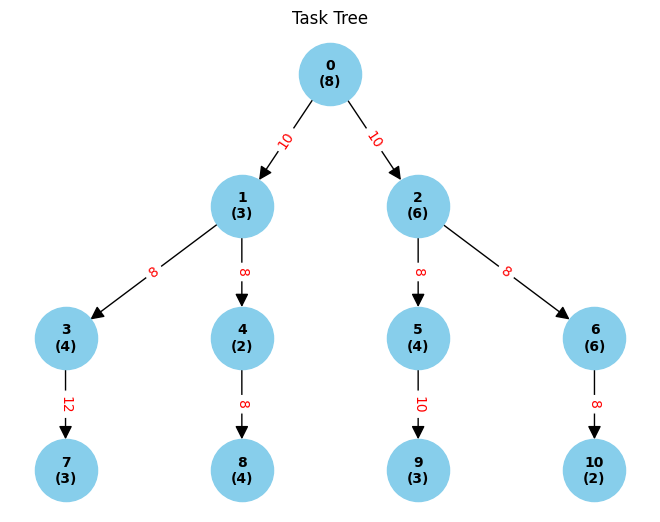

In [12]:
# Now, you can join the notebook path with the relative path to your file
file_path = os.path.join(notebook_path, "graph2")
print(file_path)

Gex_2 = read_graph(file_path)
draw(Gex_2)

### A*

In [13]:
init_state = initialize_system(G, 2)
print(init_state)
solution_path, sG = Astar(search_space=G,
                          initial_state=init_state,
                          goal_check=goal_check,
                          find_neighbors=find_neighbors,
                          heuristic=heuristic,
                          cost_between=cost_between)

print("solução encontrada: \n")

print(solution_path[-1])


  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 1

solução encontrada: 


  Processor 0, total time: 5 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 5 (with communication time: 1):
    - Task ID: 1, Execution Time: 2, Communication Time: 1
    - Task ID: 3, Execution Time: 2, Communication Time: 0
System end time: 6



Também foi pedido um padrão de output, contendo algumas informações da solução. Aqui estão elas:

In [14]:
(output_gen.generate_output((solution_path, sG), filename="output_Astar_scheduler", calculate_solution_cost=calculate_solution_cost, should_print=True))


Caminho da solução escrito  em: /home/bufulin/Desktop/IA-trabalho-1/relatorio/output_Astar_scheduler
Número de nós visitados: 5
Total de nós: 17
Profundidade da meta: 3
Custo da solução: 6


(5, 17, 3, 6)

É importante ressaltar que todos os passos para chegar na solução estão no `solution_path`. Podemos visualizar o gráfio de Gantt de cada etapa se for necessário, veja da última:

In [15]:
solution_path[-1].plot_gantt_chart()
print(solution_path[-1])


  Processor 0, total time: 5 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 5 (with communication time: 1):
    - Task ID: 1, Execution Time: 2, Communication Time: 1
    - Task ID: 3, Execution Time: 2, Communication Time: 0
System end time: 6



Agora, aplicando nos grafos do material de apoio:




In [16]:
solution_path, sG = Astar(init_state,goal_check,find_neighbors,heuristic,cost_between, search_space=Gex_1)
solution_path[-1].plot_gantt_chart()

print(solution_path[-1])



  Processor 0, total time: 33 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 4, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
    - Task ID: 5, Execution Time: 1, Communication Time: 0
    - Task ID: 4, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 4, Communication Time: 0
    - Task ID: 7, Execution Time: 3, Communication Time: 0
    - Task ID: 6, Execution Time: 6, Communication Time: 0
    - Task ID: 8, Execution Time: 4, Communication Time: 0
    - Task ID: 9, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 19 (with communication time: 16):
    - Task ID: 10, Execution Time: 3, Communication Time: 16
System end time: 35



In [17]:
solution_path, sG = Astar(init_state,goal_check,find_neighbors,heuristic,cost_between, search_space=Gex_2)
solution_path[-1].plot_gantt_chart()

print(solution_path[-1])




  Processor 0, total time: 30 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 3, Communication Time: 0
    - Task ID: 4, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 4, Communication Time: 0
    - Task ID: 7, Execution Time: 3, Communication Time: 0
    - Task ID: 2, Execution Time: 6, Communication Time: 0
    - Task ID: 5, Execution Time: 4, Communication Time: 0
    - Task ID: 9, Execution Time: 3, Communication Time: 0
    - Task ID: 8, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 16 (with communication time: 8):
    - Task ID: 6, Execution Time: 6, Communication Time: 8
    - Task ID: 10, Execution Time: 2, Communication Time: 0
System end time: 30



### Busca Gulosa

In [18]:
init_state = initialize_system(G, 2)
print(init_state)
solution_path, sG = greedy_search(G,init_state,goal_check,find_neighbors,heuristic)
print(solution_path[-1])

solution_path[-1].plot_gantt_chart()


  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 1


  Processor 0, total time: 9 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
    - Task ID: 1, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 2, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 9



Veja que interessante. O algoritmo da busca gulosa alocou todas as tarefas em um mesmo processador. Dado que a busca gulosa usa apenas a heurística para tomar a decisão, pode ser que talvez essa heurística tenha que ser melhorada. 

Abaixo, veja alguas informações sobre a solução:

In [19]:
(output_gen.generate_output((solution_path, sG), filename="output_Greedy_scheduler", calculate_solution_cost=calculate_solution_cost, should_print=True))


Caminho da solução escrito  em: /home/bufulin/Desktop/IA-trabalho-1/relatorio/output_Greedy_scheduler
Número de nós visitados: 3
Total de nós: 9
Profundidade da meta: 3
Custo da solução: 9


(3, 9, 3, 9)

Agora, nos grafos de exemplo:

In [20]:
solution_path, sG = Astar(init_state,goal_check,find_neighbors,heuristic,cost_between, search_space=Gex_1)
solution_path[-1].plot_gantt_chart()

print(solution_path[-1])



  Processor 0, total time: 33 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 4, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
    - Task ID: 5, Execution Time: 1, Communication Time: 0
    - Task ID: 4, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 4, Communication Time: 0
    - Task ID: 7, Execution Time: 3, Communication Time: 0
    - Task ID: 6, Execution Time: 6, Communication Time: 0
    - Task ID: 8, Execution Time: 4, Communication Time: 0
    - Task ID: 9, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 19 (with communication time: 16):
    - Task ID: 10, Execution Time: 3, Communication Time: 16
System end time: 35



In [21]:
solution_path, sG = Astar(init_state,goal_check,find_neighbors,heuristic,cost_between, search_space=Gex_2)
solution_path[-1].plot_gantt_chart()

print(solution_path[-1])



  Processor 0, total time: 30 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 3, Communication Time: 0
    - Task ID: 4, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 4, Communication Time: 0
    - Task ID: 7, Execution Time: 3, Communication Time: 0
    - Task ID: 2, Execution Time: 6, Communication Time: 0
    - Task ID: 5, Execution Time: 4, Communication Time: 0
    - Task ID: 9, Execution Time: 3, Communication Time: 0
    - Task ID: 8, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 16 (with communication time: 8):
    - Task ID: 6, Execution Time: 6, Communication Time: 8
    - Task ID: 10, Execution Time: 2, Communication Time: 0
System end time: 30



### Busca em profundidade iterativa

primeiro, aplicado no exemplo mais simples:

In [22]:
init_state = initialize_system(G, 2)
print(init_state)
solution_path, sG = iter_depth_search(init_state,goal_check,find_neighbors,30,G)

print("solução encontrada: \n")

solution_path[-1].plot_gantt_chart()

print(solution_path[-1])


  Processor 0, total time: 1 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 1

solução encontrada: 




  Processor 0, total time: 9 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 2, Communication Time: 0
    - Task ID: 3, Execution Time: 2, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 9



Os 2 exemplos mais complexos em seguida:

In [23]:
solution_path, sG = iter_depth_search(init_state,goal_check,find_neighbors,30,Gex_2)
solution_path[-1].plot_gantt_chart()

print(solution_path[-1])



  Processor 0, total time: 38 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 3, Communication Time: 0
    - Task ID: 2, Execution Time: 6, Communication Time: 0
    - Task ID: 3, Execution Time: 4, Communication Time: 0
    - Task ID: 4, Execution Time: 2, Communication Time: 0
    - Task ID: 5, Execution Time: 4, Communication Time: 0
    - Task ID: 6, Execution Time: 6, Communication Time: 0
    - Task ID: 7, Execution Time: 3, Communication Time: 0
    - Task ID: 8, Execution Time: 4, Communication Time: 0
    - Task ID: 9, Execution Time: 3, Communication Time: 0
    - Task ID: 10, Execution Time: 2, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 38



In [24]:
solution_path, sG = iter_depth_search(init_state,goal_check,find_neighbors,30,Gex_1)
solution_path[-1].plot_gantt_chart()

print(solution_path[-1])



  Processor 0, total time: 36 (with communication time: 0):
    - Task ID: 0, Execution Time: 1, Communication Time: 0
    - Task ID: 1, Execution Time: 4, Communication Time: 0
    - Task ID: 2, Execution Time: 4, Communication Time: 0
    - Task ID: 3, Execution Time: 4, Communication Time: 0
    - Task ID: 4, Execution Time: 2, Communication Time: 0
    - Task ID: 5, Execution Time: 1, Communication Time: 0
    - Task ID: 6, Execution Time: 6, Communication Time: 0
    - Task ID: 7, Execution Time: 3, Communication Time: 0
    - Task ID: 8, Execution Time: 4, Communication Time: 0
    - Task ID: 9, Execution Time: 4, Communication Time: 0
    - Task ID: 10, Execution Time: 3, Communication Time: 0
  Processor 1, total time: 0 (with communication time: 0):
    - Processor is free of tasks -
System end time: 36



## Bônus

Por acaso, foi feita uma função geradora de tarefas. Então podemos gerar um monte de tarefas e fazer gráficos para comparar seus resultados Em larga escala. 

### Múltiplas gerações para A estrela


In [25]:
solutions = []
for i in range(100):
    generated=generate_tree(6)
    solutions.append(Astar(initial_state=initialize_system(generated,2),
                            goal_check=goal_check, 
                            find_neighbors=find_neighbors, 
                           heuristic=heuristic,
                           cost_between=cost_between,
                           search_space=generated
                           ))


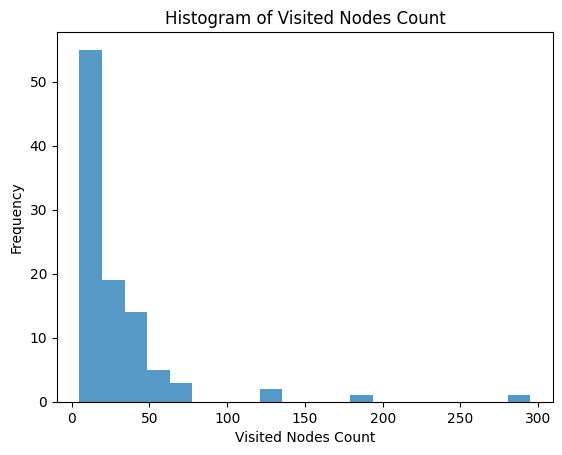

In [26]:
from matplotlib import pyplot as plt

visited_nodes_counts = [output_gen.generate_output((solution[0], solution[1]), calculate_solution_cost=calculate_solution_cost)[0]  for solution in solutions]

plt.hist(visited_nodes_counts, bins=20, alpha=0.75)
plt.title('Histogram of Visited Nodes Count')
plt.xlabel('Visited Nodes Count')
plt.ylabel('Frequency')
plt.show()

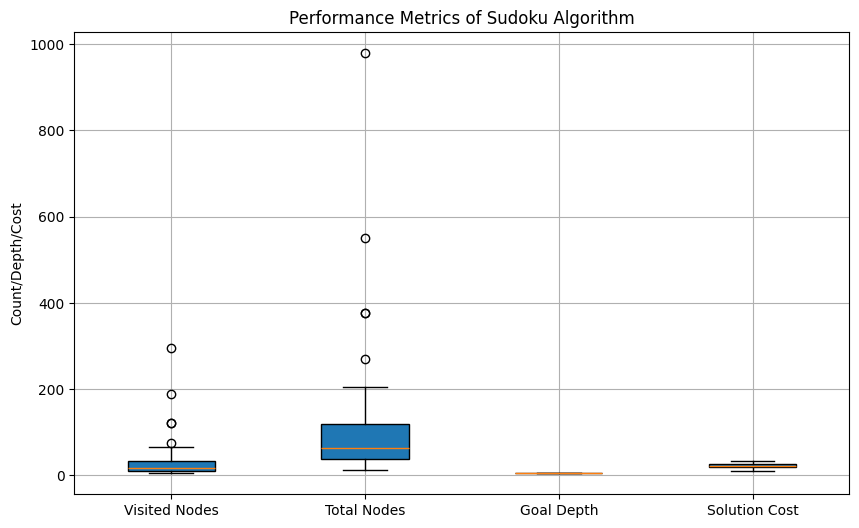

In [27]:
# Data setup
visited_nodes_counts = []
total_nodes_counts = []
goal_depths = []
solution_costs = []

# Iterate over the solutions and unpack the tuples to populate the lists
for solution in solutions:
    visited_nodes_count, total_nodes_count, goal_depth, solution_cost = output_gen.generate_output(
        (solution[0], solution[1]), 
        calculate_solution_cost=calculate_solution_cost
    )
    
    visited_nodes_counts.append(visited_nodes_count)
    total_nodes_counts.append(total_nodes_count)
    goal_depths.append(goal_depth)
    solution_costs.append(solution_cost)
labels = ['Visited Nodes', 'Total Nodes', 'Goal Depth', 'Solution Cost']


data = [visited_nodes_counts, total_nodes_counts, goal_depths, solution_costs]

# Box plot
plt.figure(figsize=(10, 6))  # You can adjust the size as needed
plt.boxplot(data, labels=labels, patch_artist=True)

# Adding titles and labels
plt.title('Performance Metrics of Sudoku Algorithm')
plt.ylabel('Count/Depth/Cost')

# Adding grid for better readability
plt.grid(True)

# Show the plot
plt.show()
